In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchvision import models
import time

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                               ])

In [2]:
training_dataset = datasets.ImageFolder(root='data/train', transform=transform)

In [3]:
training_dataset.classes

['Accident', 'Non Accident']

In [4]:
validation_dataset = datasets.ImageFolder(root='data/val', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

In [5]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
batch = next(iter(train_loader))
images,labels = batch
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


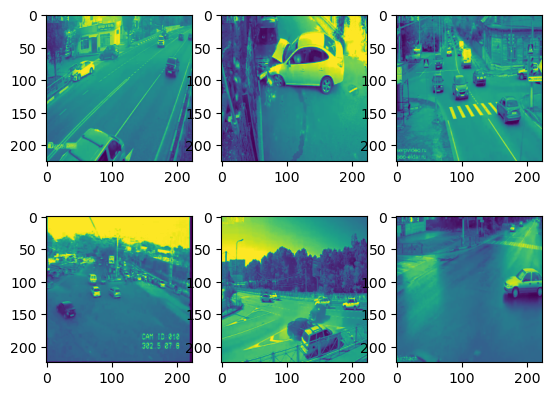

In [7]:
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i][0])
plt.show()

In [8]:
# Load the pre-trained ResNet-18 model
model = models.resnet50(weights="IMAGENET1K_V2")

# Freeze the features of the model (optional but often helps with fine-tuning)
for param in model.parameters():
    param.requires_grad = True

# Modify the final layer to be a binary classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # The output is for 2 classes: Accident and Non Accident

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

device = torch.device("cpu")
model = model.to(device)

In [9]:
# Define number of epochs
n_epochs = 5

# Lists to keep track of training progress:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

print("Training Loop Begins!")

for epoch in range(n_epochs):
    # Track time
    start_time = time.time()

    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the current device
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)
        loss_value = criterion(outputs, labels)  # Calculate the loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss_value.item() * inputs.size(0)
        correct_train += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss_value = criterion(outputs, labels)
            
            running_val_loss += loss_value.item() * inputs.size(0)
            correct_val += (preds == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    # Calculate time per epoch
    end_time = time.time()
    epoch_time = end_time - start_time

    # Print training and validation statistics 
    print(f'Epoch: {epoch+1}/{n_epochs} \tTraining Loss: {epoch_train_loss:.6f} \tValidation Loss: {epoch_val_loss:.6f} \tTraining Acc: {epoch_train_acc:.6f} \tValidation Acc: {epoch_val_acc:.6f} \tTime: {epoch_time:.2f} s')

print('Training complete!')


Training Loop Begins!
Epoch: 1/5 	Training Loss: 0.680488 	Validation Loss: 0.672285 	Training Acc: 0.553333 	Validation Acc: 0.530612 	Time: 199.71 s
Epoch: 2/5 	Training Loss: 0.665638 	Validation Loss: 0.656641 	Training Acc: 0.577333 	Validation Acc: 0.561224 	Time: 226.47 s
Epoch: 3/5 	Training Loss: 0.652894 	Validation Loss: 0.647196 	Training Acc: 0.616000 	Validation Acc: 0.602041 	Time: 212.41 s
Epoch: 4/5 	Training Loss: 0.642057 	Validation Loss: 0.639228 	Training Acc: 0.654667 	Validation Acc: 0.642857 	Time: 214.45 s
Epoch: 5/5 	Training Loss: 0.628631 	Validation Loss: 0.631206 	Training Acc: 0.698667 	Validation Acc: 0.673469 	Time: 206.42 s
Training complete!


In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

batch_acc = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    acc = accuracy(outputs, labels)
    batch_acc.append(acc)
test_accuracy = torch.stack(batch_acc).mean()
print(f"Test accuracy of Model is {test_accuracy:.4f}")

Test accuracy of Model is 0.7422


In [11]:
torch.save(model.state_dict(), "normal.pth")

In [12]:
import intel_extension_for_pytorch as ipex

In [15]:
model = model.train()

In [16]:
model , optimizer = ipex.optimize(model=model,optimizer=optimizer)

/opt/intel/inteloneapi/pytorch/latest/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:545: UserWarning: Transformer opitmization is only support on XPU now.
  warnings.warn("Transformer opitmization is only support on XPU now.")


In [17]:
# Define number of epochs
n_epochs = 15

# Lists to keep track of training progress:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

print("Training Loop Continues")
for epoch in range(5, n_epochs):
    # Track time
    start_time = time.time()

    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the current device
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)
        loss_value = criterion(outputs, labels)  # Calculate the loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss_value.item() * inputs.size(0)
        correct_train += (preds == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / len(train_loader.dataset)
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss_value = criterion(outputs, labels)
            
            running_val_loss += loss_value.item() * inputs.size(0)
            correct_val += (preds == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    # Calculate time per epoch
    end_time = time.time()
    epoch_time = end_time - start_time

    # Print training and validation statistics 
    print(f'Epoch: {epoch+1}/{n_epochs} \tTraining Loss: {epoch_train_loss:.6f} \tValidation Loss: {epoch_val_loss:.6f} \tTraining Acc: {epoch_train_acc:.6f} \tValidation Acc: {epoch_val_acc:.6f} \tTime: {epoch_time:.2f} s')

print('Training complete!')

Training Loop Continues
Epoch: 6/15 	Training Loss: 0.620799 	Validation Loss: 0.622299 	Training Acc: 0.718667 	Validation Acc: 0.683673 	Time: 166.83 s
Epoch: 7/15 	Training Loss: 0.610234 	Validation Loss: 0.613303 	Training Acc: 0.732000 	Validation Acc: 0.693878 	Time: 169.78 s
Epoch: 8/15 	Training Loss: 0.603256 	Validation Loss: 0.605513 	Training Acc: 0.742667 	Validation Acc: 0.724490 	Time: 174.86 s
Epoch: 9/15 	Training Loss: 0.589695 	Validation Loss: 0.599962 	Training Acc: 0.754667 	Validation Acc: 0.734694 	Time: 172.80 s
Epoch: 10/15 	Training Loss: 0.587109 	Validation Loss: 0.595050 	Training Acc: 0.742667 	Validation Acc: 0.724490 	Time: 178.68 s
Epoch: 11/15 	Training Loss: 0.576368 	Validation Loss: 0.587307 	Training Acc: 0.758667 	Validation Acc: 0.734694 	Time: 186.97 s
Epoch: 12/15 	Training Loss: 0.569021 	Validation Loss: 0.581883 	Training Acc: 0.757333 	Validation Acc: 0.744898 	Time: 183.02 s
Epoch: 13/15 	Training Loss: 0.561499 	Validation Loss: 0.57731

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

batch_acc = []
for inputs, labels in test_loader:
    outputs = model(inputs)
    acc = accuracy(outputs, labels)
    batch_acc.append(acc)
test_accuracy = torch.stack(batch_acc).mean()
print(f"Test accuracy of Model is {test_accuracy:.4f}")

Test accuracy of Model is 0.8047


In [19]:
torch.save(model.state_dict(), "ipex.pth")